# Multi-Strategy Portfolio Construction and Risk Analysis (2020–2022)

## Description:
Constructed five portfolio strategies — Markowitz, Global Minimum Variance, Equally Weighted, Naïve Risk Parity, and Vanilla Risk Parity — using data from 2020–2022 for 9 major U.S. stocks. Evaluated each strategy's allocations, returns, Sharpe ratios, drawdowns, and risk contributions using Python-based optimization and visual analysis.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import seaborn as sns
sns.set(style="whitegrid")
np.random.seed(42)

# ---- Setup ----
tickers = ['AAPL', 'WMT', 'TSLA', 'KO', 'BAC', 'T', 'META', 'NFLX', 'CRM']
start_date = '2020-01-01'
end_date = '2022-01-01'
prices = yf.download(tickers, start=start_date, end=end_date)['Close']
returns = prices.pct_change().dropna()
mean_returns = returns.mean() * 252
cov_matrix = returns.cov() * 252
n = len(tickers)

# ---- Portfolio Optimizers ----

def get_equal_weights():
    return np.repeat(1/n, n)

def get_inv_vol_weights():
    vol = returns.std()
    inv_vol = 1 / vol
    return (inv_vol / inv_vol.sum()).values

def get_gmv_weights():
    def objective(w): return w.T @ cov_matrix @ w
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    bounds = [(0, 1)] * n
    res = minimize(objective, np.repeat(1/n, n), bounds=bounds, constraints=constraints)
    return res.x

def get_markowitz_weights():
    def objective(w): return -((w @ mean_returns) / np.sqrt(w.T @ cov_matrix @ w))
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    bounds = [(0, 1)] * n
    res = minimize(objective, np.repeat(1/n, n), bounds=bounds, constraints=constraints)
    return res.x

def get_risk_parity_weights():
    def risk_contrib(w): return w * (cov_matrix @ w)
    def objective(w):
        rc = risk_contrib(w)
        return np.sum((rc - rc.mean()) ** 2)
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    bounds = [(0, 1)] * n
    res = minimize(objective, np.repeat(1/n, n), bounds=bounds, constraints=constraints)
    return res.x


# ---- Run Evaluations ----

weights = {
    "Markowitz": get_markowitz_weights(),
    "Global Min Var": get_gmv_weights(),
    "Equal Weighted": get_equal_weights(),
    "Inverse Volatility": get_inv_vol_weights(),
    "Vanilla Risk Parity": get_risk_parity_weights()
}

/var/folders/rf/w1c5pmc51gvg00xtlws6z9nh0000gn/T/ipykernel_22709/882603886.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  9 of 9 completed


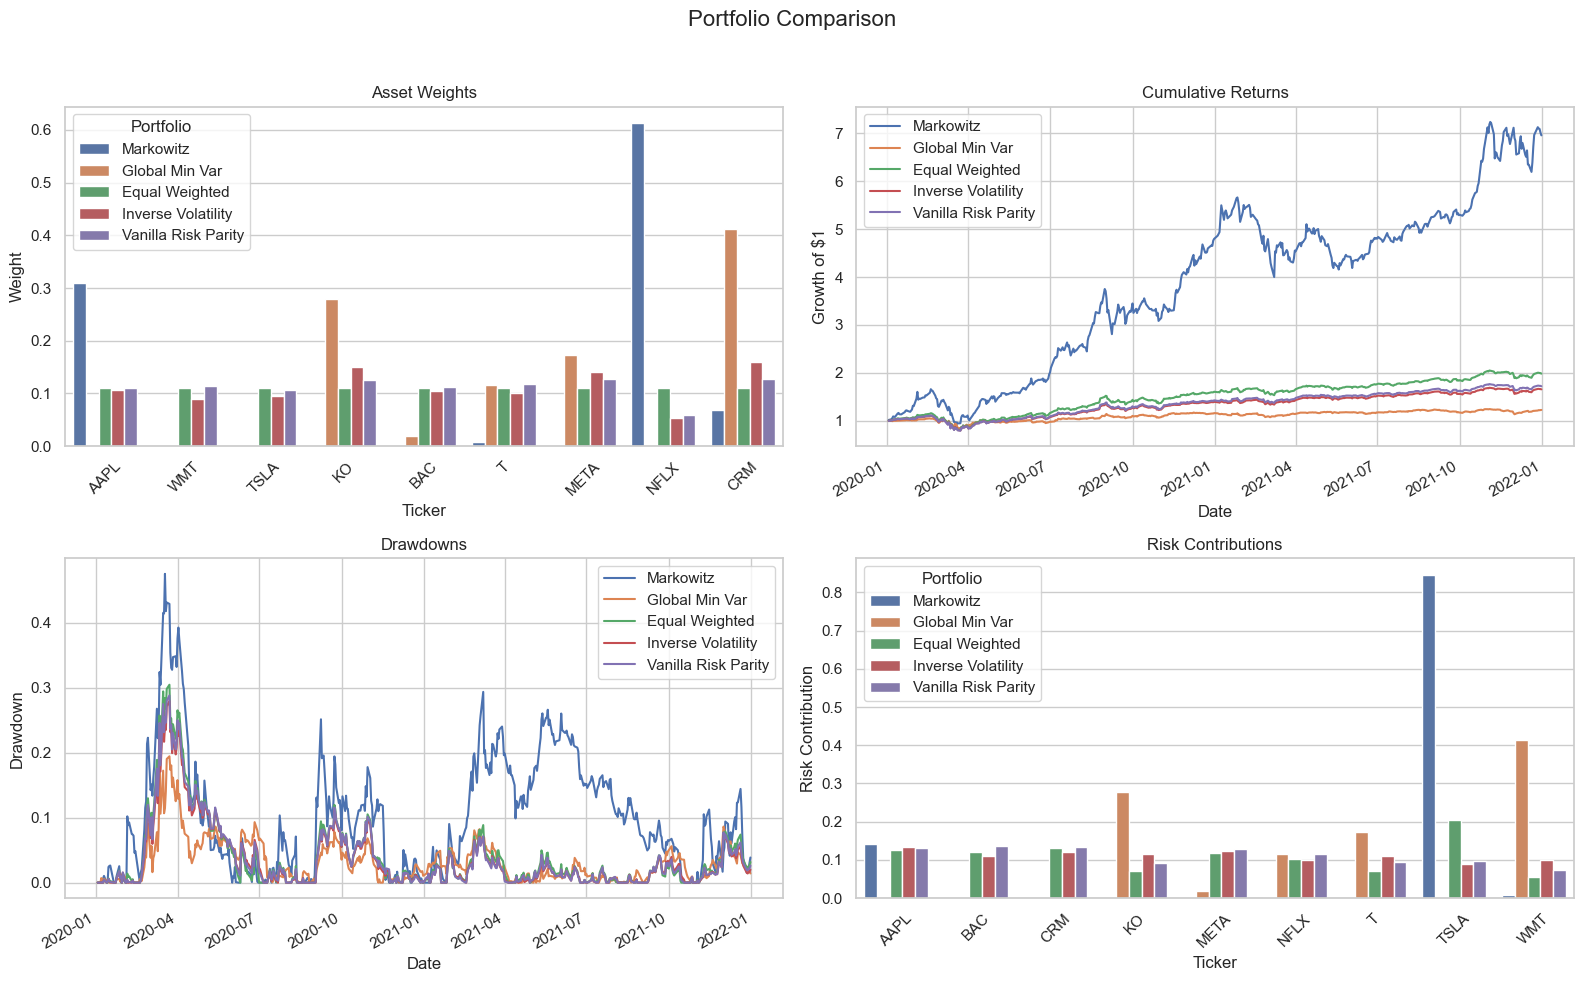

In [10]:
def evaluate_portfolios(weights_dict):
    cr, dd, rc = {}, {}, {}

    for name, w in weights_dict.items():
        port_ret = returns @ w
        cum_ret = (1 + port_ret).cumprod()
        drawdown = (cum_ret.cummax() - cum_ret) / cum_ret.cummax()
        risk_contrib = w * (cov_matrix @ w)
        risk_contrib /= risk_contrib.sum()
        cr[name], dd[name], rc[name] = cum_ret, drawdown, risk_contrib

    return pd.DataFrame(cr), pd.DataFrame(dd), pd.DataFrame(rc)

# Evaluate all
cr, dd, rc = evaluate_portfolios(weights)

# Plot all in 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle("Portfolio Comparison", fontsize=16)

# Weights
df_w = pd.DataFrame(weights, index=tickers).T.reset_index().melt(id_vars='index', var_name='Ticker', value_name='Weight').rename(columns={'index': 'Portfolio'})
sns.barplot(data=df_w, x='Ticker', y='Weight', hue='Portfolio', ax=axes[0, 0])
axes[0, 0].set_title("Asset Weights")
axes[0, 0].tick_params(axis='x', rotation=45)

# Cumulative Returns
cr.plot(ax=axes[0, 1])
axes[0, 1].set_title("Cumulative Returns")
axes[0, 1].set_ylabel("Growth of $1")

# Drawdowns
dd.plot(ax=axes[1, 0])
axes[1, 0].set_title("Drawdowns")
axes[1, 0].set_ylabel("Drawdown")

# Risk Contributions
df_rc = rc.T.reset_index().melt(id_vars='index', var_name='Ticker', value_name='Risk Contribution').rename(columns={'index': 'Portfolio'})
sns.barplot(data=df_rc, x='Ticker', y='Risk Contribution', hue='Portfolio', ax=axes[1, 1])
axes[1, 1].set_title("Risk Contributions")
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [11]:
import plotly.express as px
import pandas as pd

# --- 1. Asset Weights by Portfolio ---
fig = px.bar(df_w, x="Ticker", y="Weight", color="Portfolio", barmode="group",
             title="Asset Weights by Portfolio")
fig.update_layout(xaxis_tickangle=45)
fig.show()

# --- 2. Cumulative Returns ---
fig = px.line(cr, title="Cumulative Returns Over Time",
              labels={"value": "Growth of $1", "index": "Date"})
fig.update_layout(hovermode="x unified")
fig.show()

# --- 3. Drawdowns ---
fig = px.line(dd, title="Portfolio Drawdowns",
              labels={"value": "Drawdown", "index": "Date"})
fig.update_layout(hovermode="x unified")
fig.show()

# --- 4. Risk Contributions ---
fig = px.bar(df_rc, x="Ticker", y="Risk Contribution", color="Portfolio", barmode="group",
             title="Risk Contributions by Portfolio")
fig.update_layout(xaxis_tickangle=45)
fig.show()
